# Wasserstein GANs

This notebook implements the [Wasserstein GAN](https://arxiv.org/abs/1701.07875) with a [gradient penalty](https://arxiv.org/abs/1704.00028). The papers themselves are dense and math-heavy. The main point is found in Theorem 2 of the original WGAN paper, which posits that the earth mover distance is a much better way of learning distributions on low dimensional mainfolds (a lighter introduction can be found <a href="https://lilianweng.github.io/lil-log/2017/08/20/from-GAN-to-WGAN.html">here</a> and <a href="https://jonathan-hui.medium.com/gan-wasserstein-gan-wgan-gp-6a1a2aa1b490">here</a>). 

Some practical implications of this distance switch:

1. The discriminator is not in charge of discriminating between batches of real and fake data, but is simply there to estimate an approximation of the earth mover distance. Therefore the authors term it a *critic* instead.
2. To ensure that the loss is actually valid, we need to enforce 1-Lipschitz continuity on the critic (the norm of the gradient must be at most 1). Clipping the weights of the critic is one option, but this reduces the expressiveness of the neural network. So we opt for the gradient penalty method, and we add a regularization term to the loss of the critic for any gradient norm above 1.
3. This regularization term is there to enforce that the critic has a gradient norm of 1 almost everywhere under the distributions of real and fake data. To ensure this property efficiently (proven in the appendix of the gradient penalty paper), we can interpolate between real and fake data and use the gradient of this input to the critic as penalty.

Hence, the minimax game can be rewritten as the following,

$$
\large{
\underset{G}{\min} \underset{C}{\max} V(C, G) = \mathbb{E}_{x \sim p_{\text{data}}(x)}[C(x)] + \mathbb{E}_{z \sim p_z(z)}[C(G(z))] + \lambda \mathbb{E}[(||\nabla c(\hat{x})||_2 - 1)^2]
}
$$

Where we have $\hat{x} = \epsilon x + (1 - \epsilon)z$ with $x \sim p_{\text{data}}(z)$ and $z \sim p_z(z)$, the interpolated sample between real and fake data. Additionally, $\lambda$ and $\epsilon$ are hyperparameters with $0 \leq \epsilon \leq 1$.



Training a WGAN is more stable compared to the vanilla GAN, but the results of a WGAN are not expected to outperform the vanilla GAN and calculating the penalty makes training slow. In this notebook, we limit training to 50 epoch.

In [1]:
# Get the latest JAX, jaxlib and Flax
# !pip install --upgrade -q jax jaxlib
!pip install --upgrade -q flax

import jax
import flax

import jax.numpy as jnp
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt

from IPython.display import clear_output
from jax.nn.initializers import normal as normal_init
from flax import linen as nn

     |████████████████████████████████| 184kB 8.1MB/s 


## Loading MNIST

In [2]:
def set_range(batch):
  batch = tf.image.convert_image_dtype(batch['image'], tf.float32)
  batch = (batch - 0.5) / 0.5  # tanh range is -1, 1
  return batch
 

mnist_data = tfds.load("mnist")['train']
batches_in_epoch = len(mnist_data) // 128
 
data_gen = iter(tfds.as_numpy(
      mnist_data
        .map(set_range)
        .cache()
        .shuffle(len(mnist_data), seed=41)
        .repeat()
        .batch(128)
 ))

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.





Dataset mnist downloaded and prepared to /root/tensorflow_datasets/mnist/3.0.1. Subsequent calls will reuse this data.


## Flax Linen Architecture

In [3]:
class Generator(nn.Module):
  features: int = 64
  training: bool = True

  @nn.compact
  def __call__(self, z):
    z = z.reshape((z.shape[0], 1, 1, z.shape[1]))
    x = nn.ConvTranspose(self.features*4, [3, 3], [2, 2], 'VALID', kernel_init=normal_init(0.02))(z)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(self.features*4, [4, 4], [1, 1], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(self.features*2, [3, 3], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.relu(x)
    x = nn.ConvTranspose(1, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = jnp.tanh(x)
    return x


class Critic(nn.Module):
  features: int = 64
  training: bool = True

  @nn.compact
  def __call__(self, x):
    x = nn.Conv(self.features, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Conv(self.features*2, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = nn.BatchNorm(not self.training, -1, 0.1, scale_init=normal_init(0.02))(x)
    x = nn.leaky_relu(x, 0.2)
    x = nn.Conv(1, [4, 4], [2, 2], 'VALID', kernel_init=normal_init(0.02))(x)
    x = x.reshape((x.shape[0], -1))
    return x


def sample_latent(key, shape):
  return jax.random.normal(key, shape=shape)

## Loss Functions

In [4]:
@jax.jit
def loss_generator(params_g, params_c, vars_g, vars_c, data, key):
  latent = sample_latent(key, shape=(data.shape[0], 64))

  fake_data, vars_g = Generator().apply(
      {'params': params_g, 'batch_stats': vars_g['batch_stats']},
      latent, mutable=['batch_stats']
  )

  fake_value, vars_c = Critic().apply(
      {'params': params_c, 'batch_stats': vars_c['batch_stats']},
      fake_data, mutable=['batch_stats']
  )

  loss = jnp.mean(-fake_value)
  return loss, (vars_g, vars_c)


@jax.partial(jax.vmap, in_axes=(None, None, 0))
@jax.partial(jax.grad, argnums=2)
def critic_forward(params, vars, input_image):
  """Helper function to calculate the gradients with respect to the input."""
  value, _ = Critic().apply(
      {'params': params, 'batch_stats': vars['batch_stats']},
      input_image, mutable=['batch_stats']
  )
  return value[0, 0]


@jax.jit
def loss_critic(params_c, params_g, vars_g, vars_c, data, key):
  latent = sample_latent(key, shape=(data.shape[0], 64))

  fake_data, vars_g = Generator().apply(
      {'params': params_g, 'batch_stats': vars_g['batch_stats']},
      latent, mutable=['batch_stats']
  )

  fake_value, vars_c = Critic().apply(
      {'params': params_c, 'batch_stats': vars_c['batch_stats']},
      fake_data, mutable=['batch_stats']
  )

  real_value, vars_c = Critic().apply(
      {'params': params_c, 'batch_stats': vars_c['batch_stats']},
      data, mutable=['batch_stats']
  )

  # Interpolate between fake and real images with epsilon
  epsilon = jax.random.uniform(key, shape=(data.shape[0], 1, 1, 1))
  data_mix = data * epsilon + fake_data * (1 - epsilon)

  # Fetch the gradient penalty
  gradients = critic_forward(params_c, vars_c, data_mix)
  gradients    = gradients.reshape((gradients.shape[0], -1))
  grad_norm    = jnp.linalg.norm(gradients, axis=1)
  grad_penalty = ((grad_norm - 1) ** 2).mean()

  # here we use 10 as a fixed parameter as a cost of the penalty.
  loss = - real_value.mean() + fake_value.mean() + 10 * grad_penalty

  return loss, (vars_g, vars_c)

## Define the training step

In [5]:
@jax.jit
def train_step(data, vars_g, vars_c, optim_g, optim_c, rng):
  key, key_gen, key_crit = jax.random.split(rng, 3)

  # Train the generator
  grad_fn_generator = jax.value_and_grad(loss_generator, has_aux=True)
  (loss_g, (vars_g, vars_c)), grad_g = grad_fn_generator(
      optim_g.target, optim_c.target, vars_g, vars_c, data, key_gen
  )

  optim_g = optim_g.apply_gradient(grad_g)
  
  # We train the critic iteratively, ensuring the penalty has sufficient effect.
  grad_fn_critic = jax.value_and_grad(loss_critic, has_aux=True)
  for _ in range(5):
    key, key_crit = jax.random.split(rng, 2)
    (loss_c, (vars_g, vars_c)), grad_c = grad_fn_critic(
        optim_c.target, optim_g.target, vars_g, vars_c, data, key_crit
    )

    optim_c = optim_c.apply_gradient(grad_c)
  
  loss = {'generator': loss_g, 'critic': loss_c}
  return loss, vars_g, vars_c, optim_g, optim_c, key


@jax.jit
def eval_step(params, vars, latent):  
  fake_data, _ = Generator(training=False).apply(
      {'params': params, 'batch_stats': vars['batch_stats']},
      latent, mutable=['batch_stats']
  )

  return fake_data

## Training the model

In [6]:
def plot(images, loss, epoch):
  clear_output(True)

  # First plot the losses.
  fig, ax = plt.subplots(figsize=(10, 4))
  ax.plot(loss['generator'], label='Generator Loss')
  ax.plot(loss['critic'], label='Critic Loss')
  ax.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
  fig.suptitle(f"Epoch {epoch}")

  # Next, plot the static samples.
  fig, axes = plt.subplots(nrows=10, ncols=10, figsize=(10, 10), tight_layout=bool)
  for ax, image in zip(sum(axes.tolist(), []), images):
    ax.imshow(image[:, :, 0], cmap='gray')
    ax.set_axis_off()

  plt.show()

In [7]:
key = jax.random.PRNGKey(seed=41)
key, key_gen, key_crit, key_latent = jax.random.split(key, 4)

# Retrieve shapes for generator and discriminator input.
latent = sample_latent(key_latent, shape=(100, 64))
image_shape = next(data_gen).shape

# Generate initial variables (parameters and batch statistics).
vars_g = Generator().init(key_gen, jnp.ones(latent.shape, jnp.float32))
vars_c = Critic().init(key_crit, jnp.ones(image_shape, jnp.float32))

# Create optimizers.
optim_g = flax.optim.Adam(0.0002, 0.5, 0.999).create(vars_g['params'])
optim_c = flax.optim.Adam(0.0002, 0.5, 0.999).create(vars_c['params'])

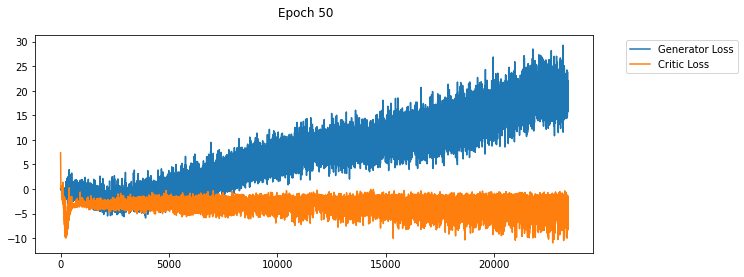

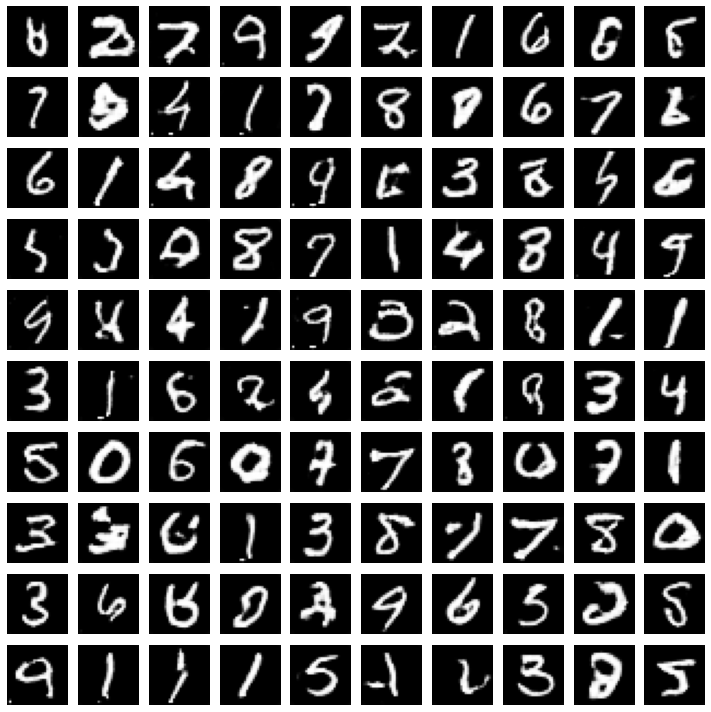

In [8]:
loss = {'generator': [], 'critic': []}

for epoch in range(1, 51):
  for batch in range(batches_in_epoch):
    data = next(data_gen)

    batch_loss, vars_g, vars_c, optim_g, optim_c, key = train_step(
        data, vars_g, vars_c, optim_g, optim_c, key
    )

    loss['generator'].append(batch_loss['generator'])
    loss['critic'].append(batch_loss['critic'])
   
  sample = eval_step(optim_g.target, vars_g, latent)
  plot(sample, loss, epoch)